<a href="https://colab.research.google.com/github/parthbishnoi-collab/ECON3916-33674-Statistical-Machine-Learning/blob/main/Lab2/Lab_2_Deflating_History_with_FRED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install the FRED API library
!pip install fredapi

In [2]:
# Install the FRED API library
!pip install fredapi

import pandas as pd
import matplotlib.pyplot as plt
from fredapi import Fred

# Authenticate
# Replace the string below with YOUR unique API key from fred.stlouisfed.org
fred = Fred(api_key='ddca00fcd3a0c46fda43d87e26791840')

In [3]:
# 1. Fetch the data series
print("Fetching data from FRED...")
wages = fred.get_series('AHETPI')
cpi = fred.get_series('CPIAUCSL')

# 2. Combine into a DataFrame
df = pd.DataFrame({'Nominal_Wage': wages, 'CPI': cpi})

# 3. Drop missing values (The wage data starts later than CPI data)
df = df.dropna()

# Inspect the raw data
print(df.head())
print(df.tail())

Fetching data from FRED...
            Nominal_Wage    CPI
1964-01-01          2.50  30.94
1964-02-01          2.50  30.91
1964-03-01          2.51  30.94
1964-04-01          2.52  30.95
1964-05-01          2.52  30.98
            Nominal_Wage      CPI
2025-07-01         31.35  322.132
2025-08-01         31.45  323.364
2025-09-01         31.52  324.368
2025-11-01         31.73  325.031
2025-12-01         31.76  326.030


In [4]:
def get_real_wage(nominal_col, cpi_col):
    """
    Takes a nominal column and a CPI column.
    Returns a new column adjusted for inflation (Real Dollars).
    """
    # 1. Get the CPI of the most recent date (Today's Prices)
    # .iloc[-1] grabs the very last row in the data
    cpi_today = cpi_col.iloc[-1]

    # 2. The Formula: (Nominal / Old_CPI) * CPI_Today
    real_col = (nominal_col / cpi_col) * cpi_today

    return real_col

# Apply the function to create a new column
# We feed the "Machine" our two columns:
df['Real_Wage'] = get_real_wage(df['Nominal_Wage'], df['CPI'])

# Check the result - Notice how Real Wages are different from Nominal!
print(df.tail())

            Nominal_Wage      CPI  Real_Wage
2025-07-01         31.35  322.132  31.729355
2025-08-01         31.45  323.364  31.709292
2025-09-01         31.52  324.368  31.681502
2025-11-01         31.73  325.031  31.827524
2025-12-01         31.76  326.030  31.760000


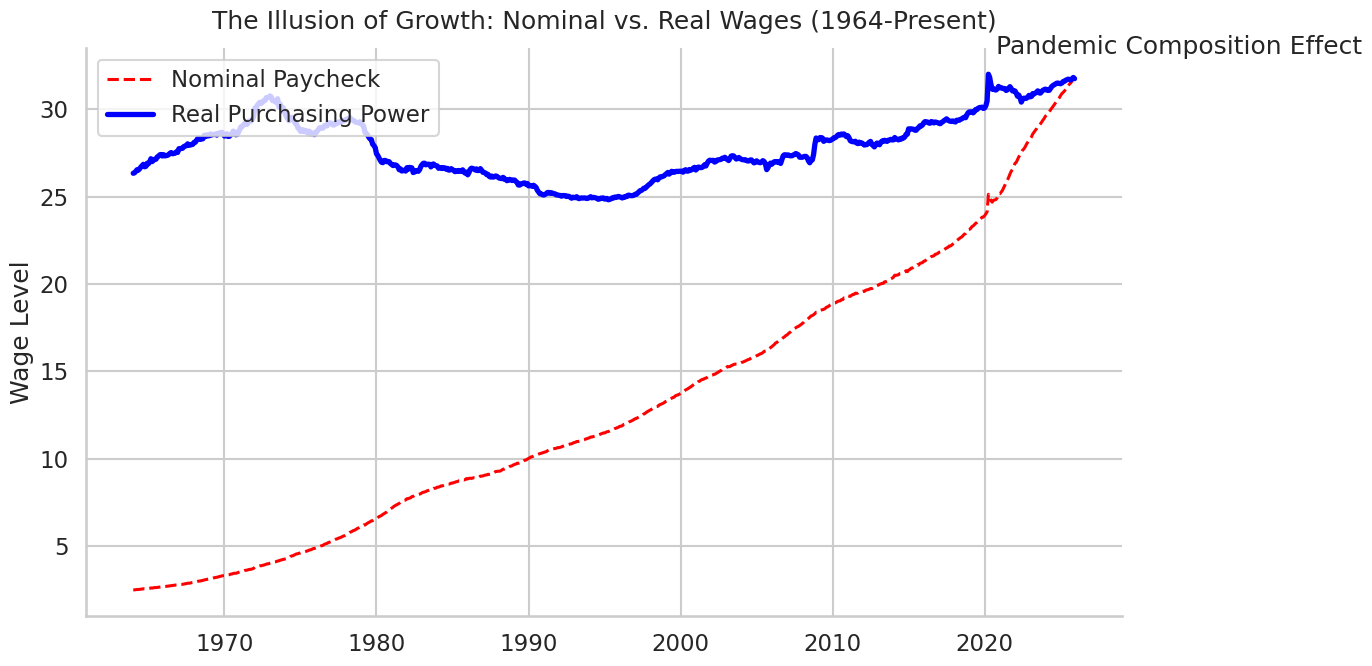

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Theme + figure defaults
sns.set_theme(style="whitegrid", context="talk")

fig, ax = plt.subplots(figsize=(14, 7))

# Plot lines
ax.plot(
    df.index, df["Nominal_Wage"],
    linestyle="--", linewidth=2.2, color="red",
    label="Nominal Paycheck"
)

ax.plot(
    df.index, df["Real_Wage"],
    linestyle="-", linewidth=3.8, color="blue",
    label="Real Purchasing Power"
)

# Title + labels
ax.set_title("The Illusion of Growth: Nominal vs. Real Wages (1964-Present)", pad=14)
ax.set_xlabel("")
ax.set_ylabel("Wage Level")

# Legend
ax.legend(frameon=True, loc="upper left")

# --- Annotation: 2020 spike in Real Wages ---
# Find the highest Real_Wage value within calendar year 2020 (robust to daily/monthly data)
df_2020 = df.loc["2020-01-01":"2020-12-31"]
if not df_2020.empty:
    spike_date = df_2020["Real_Wage"].idxmax()
    spike_val = df_2020.loc[spike_date, "Real_Wage"]

    # Place annotation text a bit to the right and above the point (time-aware offset)
    x_offset = pd.Timedelta(days=180) if isinstance(df.index, pd.DatetimeIndex) else 0
    y_offset = (df["Real_Wage"].max() - df["Real_Wage"].min()) * 0.12

    ax.annotate(
        "Pandemic Composition Effect",
        xy=(spike_date, spike_val),
        xytext=(spike_date + x_offset, spike_val + y_offset),
        arrowprops=dict(arrowstyle="->", lw=2),
        ha="left", va="bottom"
    )

# Clean up spines (optional, but usually looks more "report-ready")
sns.despine(ax=ax)

plt.tight_layout()
plt.show()


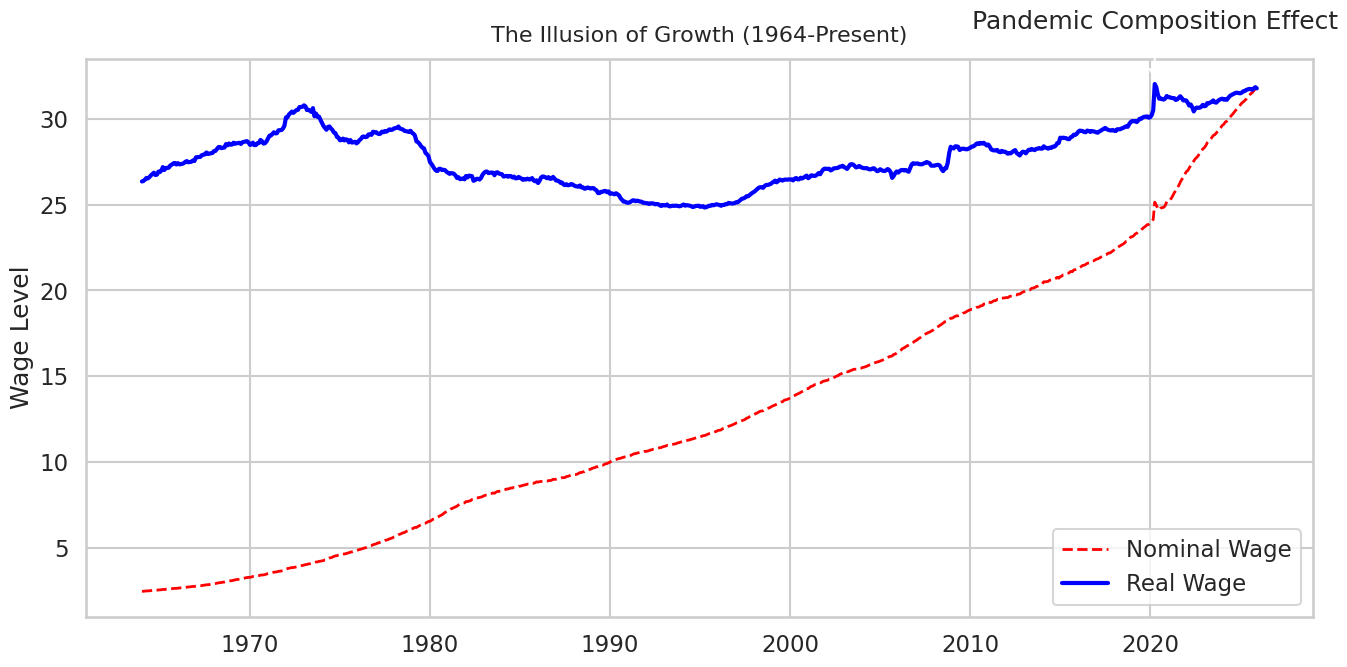

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# Create figure
fig, ax = plt.subplots(figsize=(14, 7))

# Plot both wage series
ax.plot(
    df.index,
    df["Nominal_Wage"],
    linestyle="--",
    color="red",
    linewidth=2,
    label="Nominal Wage"
)

ax.plot(
    df.index,
    df["Real_Wage"],
    linestyle="-",
    color="blue",
    linewidth=3,
    label="Real Wage"
)

# Title and labels
ax.set_title("The Illusion of Growth (1964-Present)", fontsize=16, pad=12)
ax.set_ylabel("Wage Level")

# Legend
ax.legend()

# --- Annotate 2020 spike in Real Wage ---
df_2020 = df.loc["2020-01-01":"2020-12-31"]

if not df_2020.empty:
    spike_date = df_2020["Real_Wage"].idxmax()
    spike_value = df_2020.loc[spike_date, "Real_Wage"]

    ax.annotate(
        "Pandemic Composition Effect",
        xy=(spike_date, spike_value),
        xytext=(spike_date, spike_value * 1.1),
        arrowprops=dict(arrowstyle="->", linewidth=1.5),
        ha="center"
    )

# Improve layout
plt.tight_layout()
plt.show()


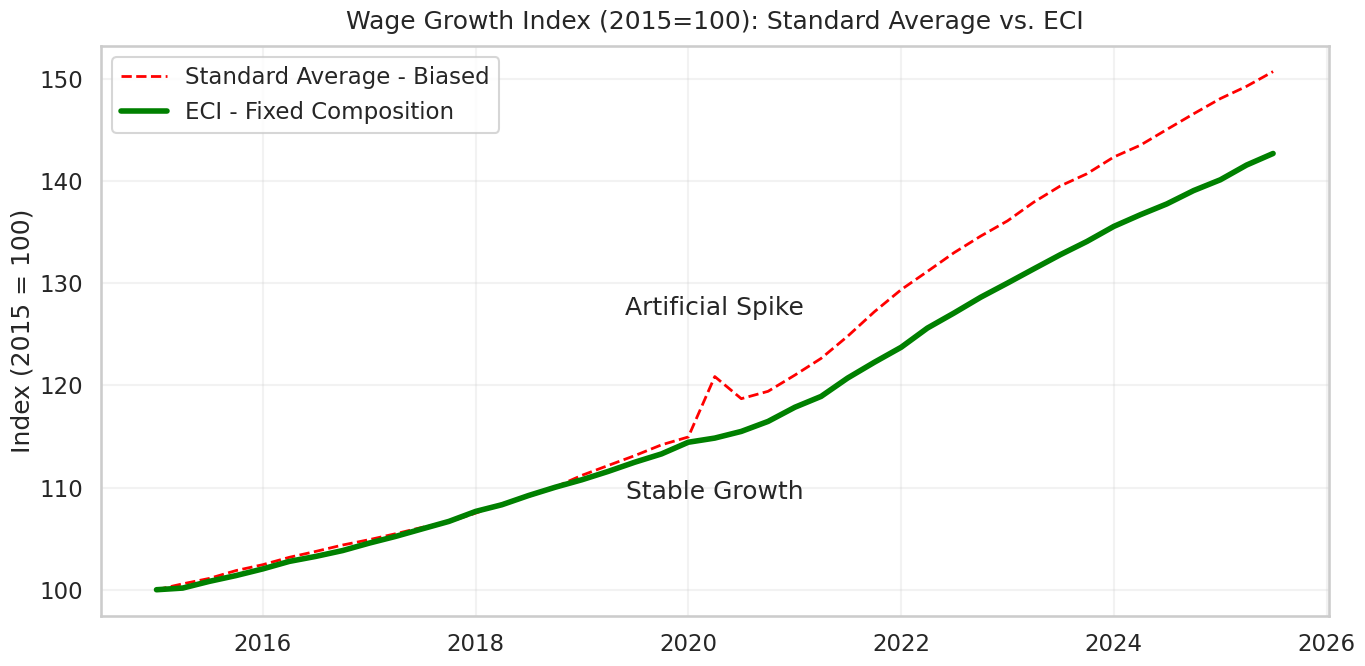

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Fetch ECI wage series (Employment Cost Index) using your existing fred object
eci = fred.get_series("ECIWAG")

# Ensure both are datetime-indexed and sorted
wages = wages.sort_index()
eci = pd.Series(eci).sort_index()
wages.index = pd.to_datetime(wages.index)
eci.index = pd.to_datetime(eci.index)

# 2) Filter to 2015-01-01 onwards
start = "2015-01-01"
wages_15 = wages.loc[start:].dropna()
eci_15 = eci.loc[start:].dropna()

# Align on common dates (keeps the comparison apples-to-apples)
wages_15, eci_15 = wages_15.align(eci_15, join="inner")

# 3) Rebase both to 100
wages_idx = (wages_15 / wages_15.iloc[0]) * 100
eci_idx   = (eci_15   / eci_15.iloc[0]) * 100

# 4) Plot both on the same chart
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(
    wages_idx.index, wages_idx.values,
    linestyle="--", color="red", linewidth=2,
    label="Standard Average - Biased"
)
ax.plot(
    eci_idx.index, eci_idx.values,
    linestyle="-", color="green", linewidth=4,
    label="ECI - Fixed Composition"
)

ax.set_title("Wage Growth Index (2015=100): Standard Average vs. ECI", pad=12)
ax.set_ylabel("Index (2015 = 100)")
ax.legend(loc="upper left")
ax.grid(True, alpha=0.25)

# 5) Annotate divergence in 2020
# Pick the date in 2020 with the largest gap between the two indexed series
gap_2020 = (wages_idx - eci_idx).loc["2020-01-01":"2020-12-31"]
if not gap_2020.empty:
    div_date = gap_2020.idxmax()
    w_val = wages_idx.loc[div_date]
    e_val = eci_idx.loc[div_date]

    # Arrow to biased spike
    ax.annotate(
        "Artificial Spike",
        xy=(div_date, w_val),
        xytext=(div_date, w_val + 6),
        arrowprops=dict(arrowstyle="->", lw=1.8),
        ha="center"
    )

    # Arrow to ECI path
    ax.annotate(
        "Stable Growth",
        xy=(div_date, e_val),
        xytext=(div_date, e_val - 6),
        arrowprops=dict(arrowstyle="->", lw=1.8),
        ha="center"
    )

plt.tight_layout()
plt.show()
